KL matrix shape: (40, 10)


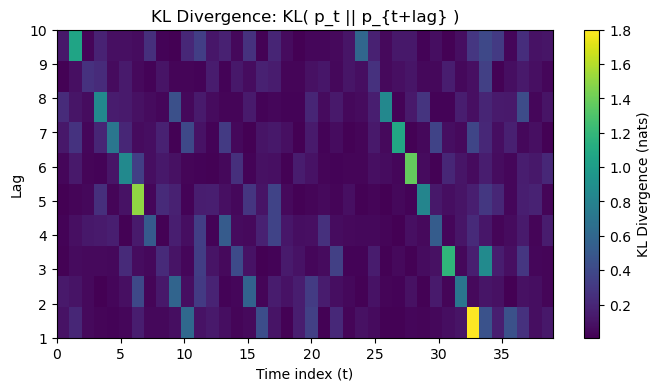

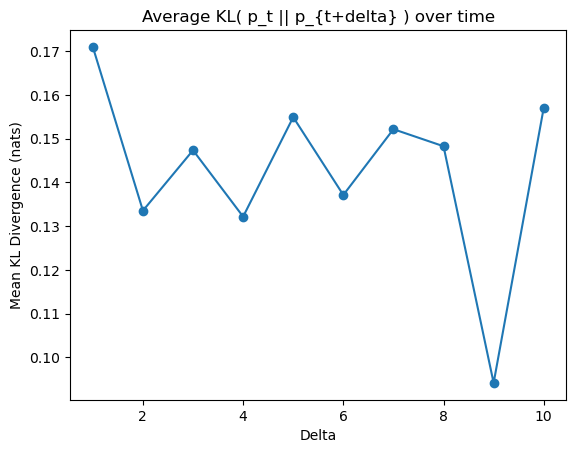

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def approximate_pdf(field_2d, bins=30, eps=1e-12):
    """
    Given a 2D field (numpy array), return a normalized 1D PDF via histogram binning.

    Args:
        field_2d: 2D numpy array representing one snapshot of the field.
        bins    : number of histogram bins.
        eps     : small offset to avoid zero probability.

    Returns:
        pdf: 1D numpy array of length 'bins' with sum(pdf)=1.
        bin_edges: the edges used for binning (optional if you need them).
    """
    data_flat = field_2d.ravel()  # Flatten into 1D
    hist, bin_edges = np.histogram(data_flat, bins=bins, density=True)
    # hist is already normalized to integrate to 1 if 'density=True'
    # but let's ensure no bin is exactly 0
    pdf = hist + eps
    pdf /= pdf.sum()  # re-normalize
    return pdf, bin_edges

def kl_divergence(p, q, eps=1e-12):
    """
    Discrete Kullback-Leibler divergence D_KL(p || q).
    p, q: 1D numpy arrays of probabilities (sum up to 1).
    eps: small offset to avoid log(0).
    Returns D_KL in 'nats' if log is natural. For log base 2 -> bits.

    We'll use natural log for demonstration.
    If you want bits, replace np.log with np.log2.
    """
    # Filter out bins where p == 0 to skip them
    mask = p > 0
    # If q[mask] has zeros, that leads to infinite D_KL. We'll clip them.
    q_ = np.clip(q[mask], eps, None)
    p_ = np.clip(p[mask], eps, None)

    return np.sum(p_ * np.log(p_ / q_))

def approximate_pdf(field_2d, bins=30, eps=1e-12):
    """
    Given a 2D field (numpy array), return a normalized 1D PDF via histogram binning.

    Args:
        field_2d: 2D numpy array representing one snapshot of the field.
        bins    : number of histogram bins.
        eps     : small offset to avoid zero probability.

    Returns:
        pdf: 1D numpy array of length 'bins' with sum(pdf)=1.
        bin_edges: the edges used for binning (optional if you need them).
    """
    data_flat = field_2d.ravel()  # Flatten into 1D
    hist, bin_edges = np.histogram(data_flat, bins=bins, density=True)
    # hist is already normalized to integrate to 1 if 'density=True'
    # but let's ensure no bin is exactly 0
    pdf = hist + eps
    pdf /= pdf.sum()  # re-normalize
    return pdf, bin_edges

def kl_divergence(p, q, eps=1e-12):
    """
    Discrete Kullback-Leibler divergence D_KL(p || q).
    p, q: 1D numpy arrays of probabilities (sum up to 1).
    eps: small offset to avoid log(0).
    Returns D_KL in 'nats' if log is natural. For log base 2 -> bits.

    We'll use natural log for demonstration.
    If you want bits, replace np.log with np.log2.
    """
    # Filter out bins where p == 0 to skip them
    mask = p > 0
    # If q[mask] has zeros, that leads to infinite D_KL. We'll clip them.
    q_ = np.clip(q[mask], eps, None)
    p_ = np.clip(p[mask], eps, None)

    return np.sum(p_ * np.log(p_ / q_))

def measure_kl_2d_fields_over_lags(fields, max_delta=10, bins=30):
    """
    Given a 3D array 'fields' of shape (T, Nx, Ny),
    for each time t and lag in [1..max_delta], compute:
        KL( p_t || p_{t+lag} )
    and store results in a 2D matrix kl_matrix[t, lag-1].

    Args:
        fields   : 3D numpy array, shape (T, Nx, Ny).
        max_delta: maximum time lag to consider.
        bins     : number of bins for the PDF approximation.

    Returns:
        kl_matrix: 2D array of shape (T - max_delta, max_delta).
                   kl_matrix[t, d] = KL( p_t || p_{t + d+1} ).
        valid_t  : the list of time indices for which we compute KL.
    """
    T, Nx, Ny = fields.shape
    kl_results = []

    # We'll only compute up to T - max_delta so that t+delta is in range
    valid_end = T - max_delta
    valid_t = range(valid_end)

    # Pre-compute PDFs for each time step
    pdfs = []
    for t in range(T):
        pdf_t, _ = approximate_pdf(fields[t], bins=bins)
        pdfs.append(pdf_t)

    for t in valid_t:
        kl_row = []
        p_t = pdfs[t]
        for delta in range(1, max_delta+1):
            q_tdelta = pdfs[t + delta]
            kl_td = kl_divergence(p_t, q_tdelta)
            kl_row.append(kl_td)
        kl_results.append(kl_row)

    kl_matrix = np.array(kl_results)  # shape = (valid_end, max_delta)
    return kl_matrix, list(valid_t)

if __name__ == "__main__":
    # 1. Generate synthetic dynamic 2D fields
    T = 50    # number of time steps
    Nx = 40
    Ny = 40

    np.random.seed(0)

    # Example: a dynamic field that shifts or changes mean over time
    fields = np.zeros((T, Nx, Ny))
    for t in range(T):
        # Base random normal field
        base = np.random.randn(Nx, Ny)
        # Add a slowly varying offset or pattern
        offset = np.sin(0.2*t) * 2.0  # example offset changing over time
        fields[t] = base + offset

    # 2. Compute KL for time lag from 1..max_delta
    max_delta = 10
    bins = 30
    kl_matrix, valid_t = measure_kl_2d_fields_over_lags(fields, max_delta, bins)

    # kl_matrix shape = (T - max_delta, max_delta)
    print("KL matrix shape:", kl_matrix.shape)

    # 3. Plot KL(t, delta)
    plt.figure(figsize=(8, 4))
    plt.imshow(kl_matrix.T, aspect='auto', origin='lower',
               extent=[valid_t[0], valid_t[-1], 1, max_delta])
    plt.colorbar(label='KL Divergence (nats)')
    plt.xlabel('Time index (t)')
    plt.ylabel('Lag')
    plt.title('KL Divergence: KL( p_t || p_{t+lag} )')
    plt.show()

    # 4. Optionally, show average KL vs. delta
    kl_mean_per_delta = np.mean(kl_matrix, axis=0)
    deltas = np.arange(1, max_delta+1)

    plt.figure()
    plt.plot(deltas, kl_mean_per_delta, marker='o')
    plt.xlabel('Delta')
    plt.ylabel('Mean KL Divergence (nats)')
    plt.title('Average KL( p_t || p_{t+delta} ) over time')
    plt.show()
